# 100-200 new 

Duration: 100 seconds
MAC Rules - Accuracy: 0.9989, Precision: 0.9981, Recall: 1.0000, F1-Score: 0.9990
MAC-IP Rules - Accuracy: 0.9985, Precision: 0.9973, Recall: 1.0000, F1-Score: 0.9987
MAC-IP-Protocol Rules - Accuracy: 0.9983, Precision: 0.9969, Recall: 1.0000, F1-Score: 0.9984

Duration: 110 seconds
MAC Rules - Accuracy: 0.9989, Precision: 0.9981, Recall: 1.0000, F1-Score: 0.9990
MAC-IP Rules - Accuracy: 0.9985, Precision: 0.9973, Recall: 1.0000, F1-Score: 0.9987
MAC-IP-Protocol Rules - Accuracy: 0.9983, Precision: 0.9969, Recall: 1.0000, F1-Score: 0.9984

Duration: 120 seconds
MAC Rules - Accuracy: 0.9989, Precision: 0.9981, Recall: 1.0000, F1-Score: 0.9990
MAC-IP Rules - Accuracy: 0.9985, Precision: 0.9973, Recall: 1.0000, F1-Score: 0.9987
MAC-IP-Protocol Rules - Accuracy: 0.9983, Precision: 0.9969, Recall: 1.0000, F1-Score: 0.9984

Duration: 130 seconds
MAC Rules - Accuracy: 0.9989, Precision: 0.9981, Recall: 1.0000, F1-Score: 0.9990
MAC-IP Rules - Accuracy: 0.9985, Precision: 

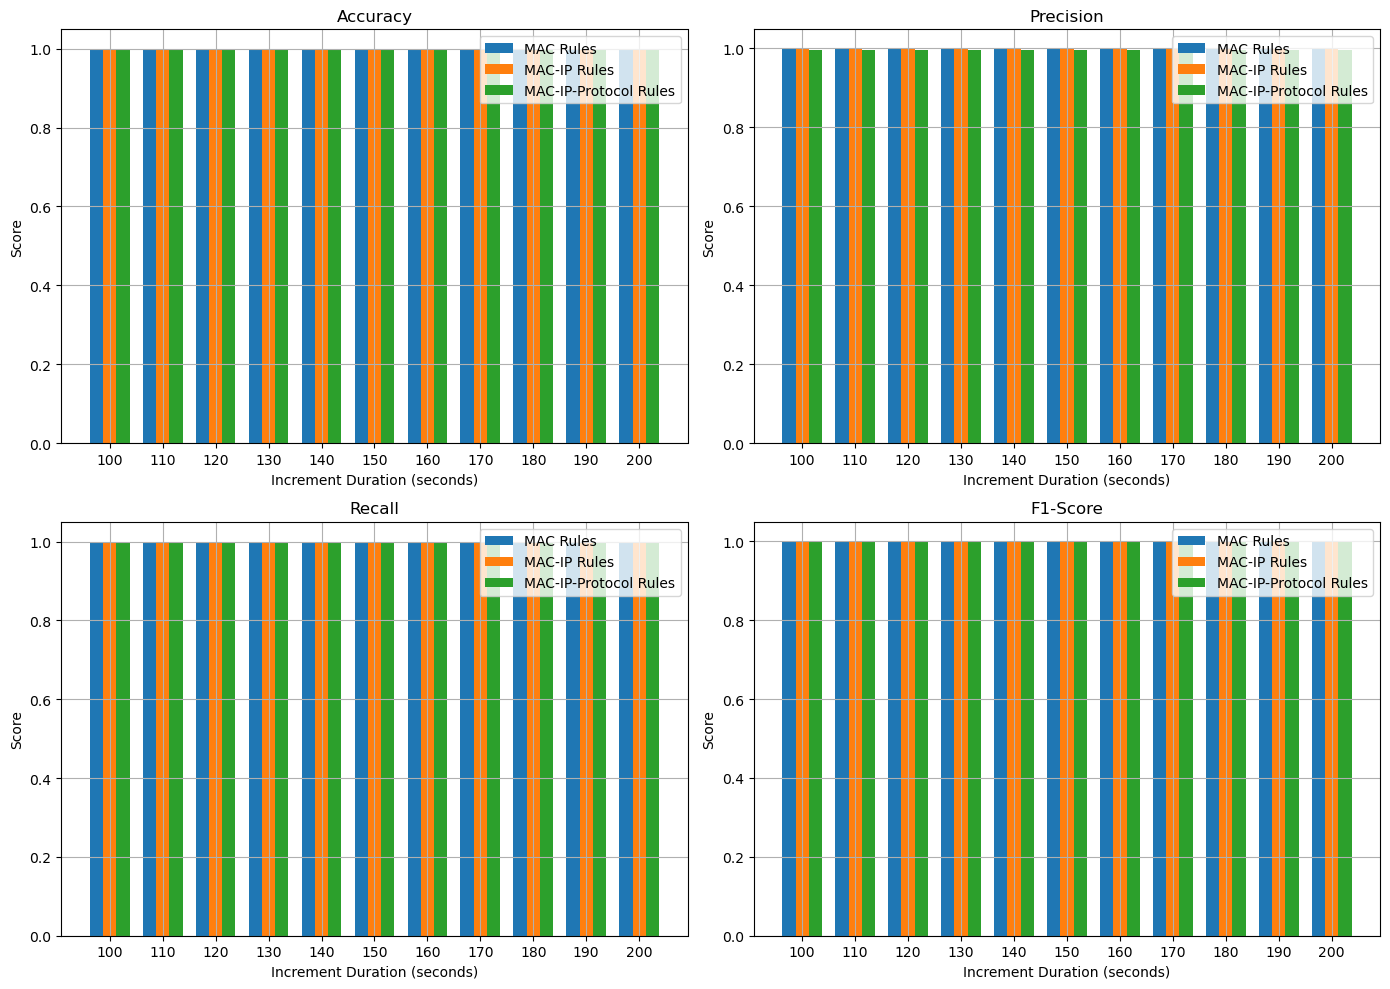

In [1]:
import subprocess
import pandas as pd
from io import StringIO
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_pcap_duration(pcap_file):
    tshark_cmd = ["tshark", "-r", pcap_file, "-T", "fields", "-e", "frame.time_epoch"]
    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    times = [float(line) for line in output.strip().split("\n")]
    start_time = min(times)
    end_time = max(times)
    return start_time, end_time

def extract_rules_tshark(pcap_file, start, end):
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        '-E', 'occurrence=f',
        '-E', 'quote=d',
        '-e', 'ip.src',
        '-e', 'ip.dst',
        '-e', 'tcp.srcport',
        '-e', 'tcp.dstport',
        '-e', 'frame.time_epoch',
        '-e', 'frame.len',
        '-e', 'ip.proto',
        '-e', '_ws.col.Protocol',
        '-e', 'eth.src',
        '-e', 'eth.dst',
        '-e', 'udp.srcport',
        '-e', 'udp.dstport'
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    df = df[(df['frame.time_epoch'] >= start) & (df['frame.time_epoch'] <= end)]

    mac_rules = set(zip(df['eth.src'], df['eth.dst']))
    mac_ip_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst']))
    mac_ip_proto_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst'], df['ip.proto']))

    return mac_rules, mac_ip_rules, mac_ip_proto_rules

def check_anomalies_tshark(pcap_file, normal_rules):
    mac_rules, mac_ip_rules, mac_ip_proto_rules = normal_rules
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        "-e", "frame.time_epoch",
        "-e", "eth.src",
        "-e", "eth.dst",
        "-e", "ip.src",
        "-e", "ip.dst",
        "-e", "ip.proto"
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    anomalies = []

    for _, row in df.iterrows():
        eth_src = row['eth.src']
        eth_dst = row['eth.dst']
        ip_src = row['ip.src']
        ip_dst = row['ip.dst']
        proto = row['ip.proto']

        mac_anomaly = 1 if (eth_src, eth_dst) not in mac_rules else 0
        mac_ip_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst) not in mac_ip_rules else 0
        mac_ip_proto_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst, proto) not in mac_ip_proto_rules else 0

        anomalies.append({
            'eth_src': eth_src,
            'eth_dst': eth_dst,
            'ip_src': ip_src,
            'ip_dst': ip_dst,
            'proto': proto,
            'mac_anomaly': mac_anomaly,
            'mac_ip_anomaly': mac_ip_anomaly,
            'mac_ip_proto_anomaly': mac_ip_proto_anomaly
        })

    return anomalies

def evaluate_anomalies(anomalies_df, true_labels_df):
    min_length = min(len(anomalies_df), len(true_labels_df))
    anomalies_df = anomalies_df.iloc[:min_length]
    true_labels_df = true_labels_df.iloc[:min_length]

    anomalies_df.index = true_labels_df.index

    metrics = {}

    def compute_metrics(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return tn, fp, fn, tp, accuracy, precision, recall, f1

 
    metrics['mac'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_anomaly'])
    metrics['mac_ip'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_anomaly'])
    metrics['mac_ip_proto'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_proto_anomaly'])

    return metrics

def process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules):
    anomalies = check_anomalies_tshark(pcap_attack, normal_rules)
    anomalies_df = pd.DataFrame(anomalies)

    true_labels_df = pd.read_csv(true_labels_csv, sep=';', header=None)
    true_labels_df.columns = ['index', 'label']
    true_labels_df.set_index('index', inplace=True)

    metrics = evaluate_anomalies(anomalies_df, true_labels_df)
    return metrics


pcap_normal = 'normal.pcap'
pcap_attack = 'characterization_modbus_6RTU_with_operate.pcap'
true_labels_csv = 'characterization_modbus_6RTU_with_operate_labeled.csv'

import mplcursors
import numpy as np
import matplotlib.pyplot as plt

# Get the start and end times of the normal pcap
start_time, end_time = get_pcap_duration(pcap_normal)

# Base duration for the first 100 seconds
base_duration = 100
base_start = start_time
base_end = start_time + base_duration

# Durations for incremental segments
increment_durations = list(range(100, 201, 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

# Extract rules for the base 100 seconds
combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, base_start, base_end)

for increment in increment_durations:
    end = start_time + increment
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, start_time, end)
    
    # Merge the base rules with the new increment rules
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((increment, metrics))

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    print(f"Duration: {duration} seconds")
    print(f"MAC Rules - Accuracy: {mac_metrics[4]:.4f}, Precision: {mac_metrics[5]:.4f}, Recall: {mac_metrics[6]:.4f}, F1-Score: {mac_metrics[7]:.4f}")
    print(f"MAC-IP Rules - Accuracy: {mac_ip_metrics[4]:.4f}, Precision: {mac_ip_metrics[5]:.4f}, Recall: {mac_ip_metrics[6]:.4f}, F1-Score: {mac_ip_metrics[7]:.4f}")
    print(f"MAC-IP-Protocol Rules - Accuracy: {mac_ip_proto_metrics[4]:.4f}, Precision: {mac_ip_proto_metrics[5]:.4f}, Recall: {mac_ip_proto_metrics[6]:.4f}, F1-Score: {mac_ip_proto_metrics[7]:.4f}")
    print()

# Aggregating the results 
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    accuracy = [mac_metrics[4], mac_ip_metrics[4], mac_ip_proto_metrics[4]]
    precision = [mac_metrics[5], mac_ip_metrics[5], mac_ip_proto_metrics[5]]
    recall = [mac_metrics[6], mac_ip_metrics[6], mac_ip_proto_metrics[6]]
    f1 = [mac_metrics[7], mac_ip_metrics[7], mac_ip_proto_metrics[7]]

    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

# Transposing the metrics 
all_accuracies = np.array(all_accuracies).T
all_precisions = np.array(all_precisions).T
all_recalls = np.array(all_recalls).T
all_f1s = np.array(all_f1s).T

# Plotting aggregated results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

x = np.arange(len(increment_durations))
width = 0.25

# Accuracy
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 0].bar(x + i * width, all_accuracies[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 0].set_xticks(x + width)
axs[0, 0].set_xticklabels(increment_durations)
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Precision
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 1].bar(x + i * width, all_precisions[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 1].set_xticks(x + width)
axs[0, 1].set_xticklabels(increment_durations)
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Recall
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 0].bar(x + i * width, all_recalls[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 0].set_xticks(x + width)
axs[1, 0].set_xticklabels(increment_durations)
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plotting F1-Score
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 1].bar(x + i * width, all_f1s[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 1].set_xticks(x + width)
axs[1, 1].set_xticklabels(increment_durations)
axs[1, 1].set_title('F1-Score')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set_xlabel('Increment Duration (seconds)')
    ax.set_ylabel('Score')
    ax.grid(True)

plt.tight_layout()
plt.show()


# 100-400 seconds

In [3]:
import subprocess
import pandas as pd
from io import StringIO
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_pcap_duration(pcap_file):
    tshark_cmd = ["tshark", "-r", pcap_file, "-T", "fields", "-e", "frame.time_epoch"]
    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    times = [float(line) for line in output.strip().split("\n")]
    start_time = min(times)
    end_time = max(times)
    return start_time, end_time

def extract_rules_tshark(pcap_file, start, end):
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        '-E', 'occurrence=f',
        '-E', 'quote=d',
        '-e', 'ip.src',
        '-e', 'ip.dst',
        '-e', 'tcp.srcport',
        '-e', 'tcp.dstport',
        '-e', 'frame.time_epoch',
        '-e', 'frame.len',
        '-e', 'ip.proto',
        '-e', '_ws.col.Protocol',
        '-e', 'eth.src',
        '-e', 'eth.dst',
        '-e', 'udp.srcport',
        '-e', 'udp.dstport'
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    df = df[(df['frame.time_epoch'] >= start) & (df['frame.time_epoch'] <= end)]

    mac_rules = set(zip(df['eth.src'], df['eth.dst']))
    mac_ip_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst']))
    mac_ip_proto_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst'], df['ip.proto']))

    return mac_rules, mac_ip_rules, mac_ip_proto_rules

def check_anomalies_tshark(pcap_file, normal_rules):
    mac_rules, mac_ip_rules, mac_ip_proto_rules = normal_rules
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        "-e", "frame.time_epoch",
        "-e", "eth.src",
        "-e", "eth.dst",
        "-e", "ip.src",
        "-e", "ip.dst",
        "-e", "ip.proto"
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    anomalies = []

    for _, row in df.iterrows():
        eth_src = row['eth.src']
        eth_dst = row['eth.dst']
        ip_src = row['ip.src']
        ip_dst = row['ip.dst']
        proto = row['ip.proto']

        mac_anomaly = 1 if (eth_src, eth_dst) not in mac_rules else 0
        mac_ip_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst) not in mac_ip_rules else 0
        mac_ip_proto_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst, proto) not in mac_ip_proto_rules else 0

        anomalies.append({
            'eth_src': eth_src,
            'eth_dst': eth_dst,
            'ip_src': ip_src,
            'ip_dst': ip_dst,
            'proto': proto,
            'mac_anomaly': mac_anomaly,
            'mac_ip_anomaly': mac_ip_anomaly,
            'mac_ip_proto_anomaly': mac_ip_proto_anomaly
        })

    return anomalies

def evaluate_anomalies(anomalies_df, true_labels_df):
    min_length = min(len(anomalies_df), len(true_labels_df))
    anomalies_df = anomalies_df.iloc[:min_length]
    true_labels_df = true_labels_df.iloc[:min_length]

    anomalies_df.index = true_labels_df.index

    metrics = {}

    def compute_metrics(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return tn, fp, fn, tp, accuracy, precision, recall, f1

 
    metrics['mac'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_anomaly'])
    metrics['mac_ip'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_anomaly'])
    metrics['mac_ip_proto'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_proto_anomaly'])

    return metrics

def process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules):
    anomalies = check_anomalies_tshark(pcap_attack, normal_rules)
    anomalies_df = pd.DataFrame(anomalies)

    true_labels_df = pd.read_csv(true_labels_csv, sep=';', header=None)
    true_labels_df.columns = ['index', 'label']
    true_labels_df.set_index('index', inplace=True)

    metrics = evaluate_anomalies(anomalies_df, true_labels_df)
    return metrics


pcap_normal = 'normal.pcap'
pcap_attack = 'send_a_fake_command_modbus_6RTU_with_operate.pcap'
true_labels_csv = 'send_a_fake_command_modbus_6RTU_with_operate_labeled.csv'

import mplcursors
import numpy as np
import matplotlib.pyplot as plt

start_time, end_time = get_pcap_duration(pcap_normal)

base_duration = 100
base_start = start_time
base_end = start_time + base_duration


increment_durations = list(range(100, 401, 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

# Extract rules for the base 100 seconds
combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, base_start, base_end)

for increment in increment_durations:
    end = start_time + increment
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, start_time, end)
    
    
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((increment, metrics))

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    print(f"Duration: {duration} seconds")
    print(f"MAC Rules - Accuracy: {mac_metrics[4]:.4f}, Precision: {mac_metrics[5]:.4f}, Recall: {mac_metrics[6]:.4f}, F1-Score: {mac_metrics[7]:.4f}")
    print(f"MAC-IP Rules - Accuracy: {mac_ip_metrics[4]:.4f}, Precision: {mac_ip_metrics[5]:.4f}, Recall: {mac_ip_metrics[6]:.4f}, F1-Score: {mac_ip_metrics[7]:.4f}")
    print(f"MAC-IP-Protocol Rules - Accuracy: {mac_ip_proto_metrics[4]:.4f}, Precision: {mac_ip_proto_metrics[5]:.4f}, Recall: {mac_ip_proto_metrics[6]:.4f}, F1-Score: {mac_ip_proto_metrics[7]:.4f}")
    print()


# Aggregating the results 
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    accuracy = [mac_metrics[4], mac_ip_metrics[4], mac_ip_proto_metrics[4]]
    precision = [mac_metrics[5], mac_ip_metrics[5], mac_ip_proto_metrics[5]]
    recall = [mac_metrics[6], mac_ip_metrics[6], mac_ip_proto_metrics[6]]
    f1 = [mac_metrics[7], mac_ip_metrics[7], mac_ip_proto_metrics[7]]

    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

# Transposing the metrics 
all_accuracies = np.array(all_accuracies).T
all_precisions = np.array(all_precisions).T
all_recalls = np.array(all_recalls).T
all_f1s = np.array(all_f1s).T


Duration: 100 seconds
MAC Rules - Accuracy: 0.9975, Precision: 0.2632, Recall: 1.0000, F1-Score: 0.4167
MAC-IP Rules - Accuracy: 0.9970, Precision: 0.2273, Recall: 1.0000, F1-Score: 0.3704
MAC-IP-Protocol Rules - Accuracy: 0.9969, Precision: 0.2222, Recall: 1.0000, F1-Score: 0.3636

Duration: 110 seconds
MAC Rules - Accuracy: 0.9975, Precision: 0.2632, Recall: 1.0000, F1-Score: 0.4167
MAC-IP Rules - Accuracy: 0.9970, Precision: 0.2273, Recall: 1.0000, F1-Score: 0.3704
MAC-IP-Protocol Rules - Accuracy: 0.9969, Precision: 0.2222, Recall: 1.0000, F1-Score: 0.3636

Duration: 120 seconds
MAC Rules - Accuracy: 0.9975, Precision: 0.2632, Recall: 1.0000, F1-Score: 0.4167
MAC-IP Rules - Accuracy: 0.9970, Precision: 0.2273, Recall: 1.0000, F1-Score: 0.3704
MAC-IP-Protocol Rules - Accuracy: 0.9969, Precision: 0.2222, Recall: 1.0000, F1-Score: 0.3636

Duration: 130 seconds
MAC Rules - Accuracy: 0.9975, Precision: 0.2632, Recall: 1.0000, F1-Score: 0.4167
MAC-IP Rules - Accuracy: 0.9970, Precision: 

AttributeError: 'DataFrame' object has no attribute 'append'

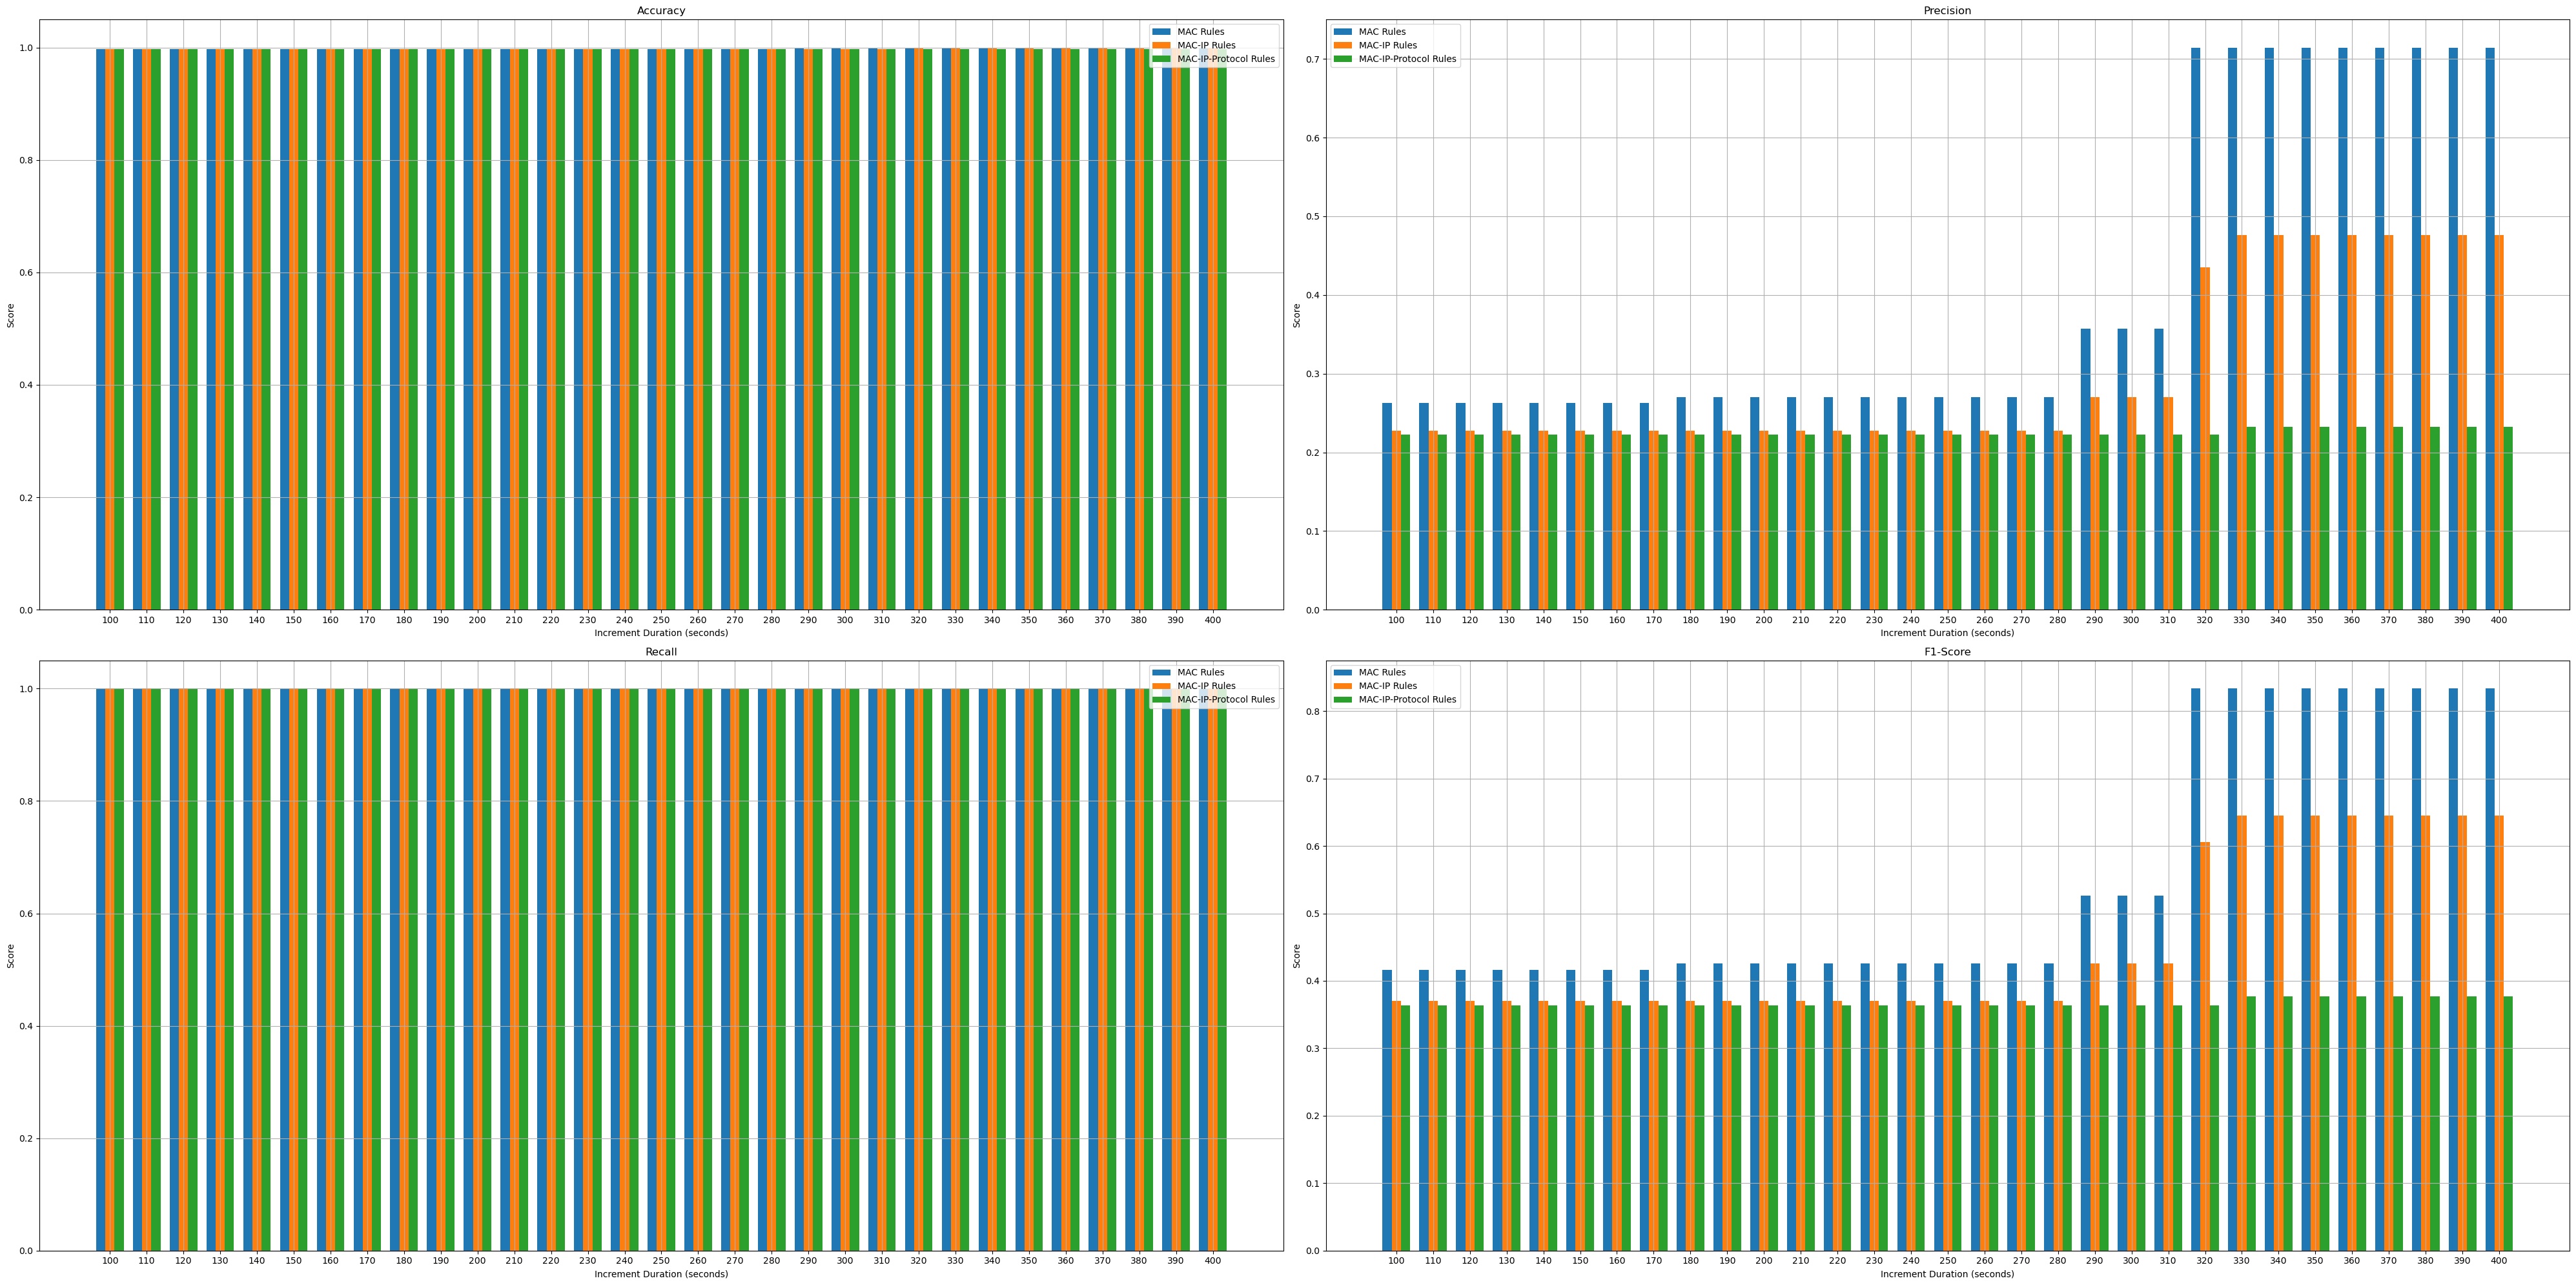

In [4]:

# Plots
fig, axs = plt.subplots(2, 2, figsize=(40, 20))

x = np.arange(len(increment_durations))
width = 0.25

# Accuracy
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 0].bar(x + i * width, all_accuracies[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 0].set_xticks(x + width)
axs[0, 0].set_xticklabels(increment_durations)
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Precision
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 1].bar(x + i * width, all_precisions[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 1].set_xticks(x + width)
axs[0, 1].set_xticklabels(increment_durations)
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Recall
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 0].bar(x + i * width, all_recalls[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 0].set_xticks(x + width)
axs[1, 0].set_xticklabels(increment_durations)
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plotting F1-Score
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 1].bar(x + i * width, all_f1s[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 1].set_xticks(x + width)
axs[1, 1].set_xticklabels(increment_durations)
axs[1, 1].set_title('F1-Score')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set_xlabel('Increment Duration (seconds)')
    ax.set_ylabel('Score')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Initialize results_df if it's not already defined
results_df = pd.DataFrame(columns=['Duration', 'Rule_Type', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Iterate over the results
for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    # Create dictionaries for the new rows
    new_rows = [
        {
            'Duration': duration,
            'Rule_Type': 'MAC',
            'Accuracy': mac_metrics[4],
            'Precision': mac_metrics[5],
            'Recall': mac_metrics[6],
            'F1-Score': mac_metrics[7]
        },
        {
            'Duration': duration,
            'Rule_Type': 'MAC-IP',
            'Accuracy': mac_ip_metrics[4],
            'Precision': mac_ip_metrics[5],
            'Recall': mac_ip_metrics[6],
            'F1-Score': mac_ip_metrics[7]
        },
        {
            'Duration': duration,
            'Rule_Type': 'MAC-IP-Proto',
            'Accuracy': mac_ip_proto_metrics[4],
            'Precision': mac_ip_proto_metrics[5],
            'Recall': mac_ip_proto_metrics[6],
            'F1-Score': mac_ip_proto_metrics[7]
        }
    ]

    # Convert the list of dictionaries to a DataFrame
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the new rows to results_df
    results_df = pd.concat([results_df, new_rows_df], ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('experiment_results-100-400.csv', index=False)

print(results_df)


C:\Users\IRFAN\AppData\Local\Temp\ipykernel_15784\3274699926.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_rows_df], ignore_index=True)


   Duration     Rule_Type  Accuracy  Precision  Recall  F1-Score
0       100           MAC  0.997492   0.263158     1.0  0.416667
1       100        MAC-IP  0.996955   0.227273     1.0  0.370370
2       100  MAC-IP-Proto  0.996865   0.222222     1.0  0.363636
3       110           MAC  0.997492   0.263158     1.0  0.416667
4       110        MAC-IP  0.996955   0.227273     1.0  0.370370
..      ...           ...       ...        ...     ...       ...
88      390        MAC-IP  0.999015   0.476190     1.0  0.645161
89      390  MAC-IP-Proto  0.997045   0.232558     1.0  0.377358
90      400           MAC  0.999642   0.714286     1.0  0.833333
91      400        MAC-IP  0.999015   0.476190     1.0  0.645161
92      400  MAC-IP-Proto  0.997045   0.232558     1.0  0.377358

[93 rows x 6 columns]


In [14]:
results_df

,Duration,Rule_Type,Accuracy,Precision,Recall,F1-Score
0,100,MAC,0.997492,0.263158,1.0,0.416667
1,100,MAC-IP,0.996955,0.227273,1.0,0.370370
2,100,MAC-IP-Proto,0.996865,0.222222,1.0,0.363636
3,110,MAC,0.997492,0.263158,1.0,0.416667
4,110,MAC-IP,0.996955,0.227273,1.0,0.370370
...,...,...,...,...,...,...
88,390,MAC-IP,0.999015,0.476190,1.0,0.645161
89,390,MAC-IP-Proto,0.997045,0.232558,1.0,0.377358
90,400,MAC,0.999642,0.714286,1.0,0.833333
91,400,MAC-IP,0.999015,0.476190,1.0,0.645161


# 100-600 seconds

In [15]:

start_time, end_time = get_pcap_duration(pcap_normal)

base_duration = 100
base_start = start_time
base_end = start_time + base_duration

increment_durations = list(range(100, 601, 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, base_start, base_end)

for increment in increment_durations:
    end = start_time + increment
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, start_time, end)
    
    # Merge the base rules with the new increment rules
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((increment, metrics))

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    print(f"Duration: {duration} seconds")
    print(f"MAC Rules - Accuracy: {mac_metrics[4]:.4f}, Precision: {mac_metrics[5]:.4f}, Recall: {mac_metrics[6]:.4f}, F1-Score: {mac_metrics[7]:.4f}")
    print(f"MAC-IP Rules - Accuracy: {mac_ip_metrics[4]:.4f}, Precision: {mac_ip_metrics[5]:.4f}, Recall: {mac_ip_metrics[6]:.4f}, F1-Score: {mac_ip_metrics[7]:.4f}")
    print(f"MAC-IP-Protocol Rules - Accuracy: {mac_ip_proto_metrics[4]:.4f}, Precision: {mac_ip_proto_metrics[5]:.4f}, Recall: {mac_ip_proto_metrics[6]:.4f}, F1-Score: {mac_ip_proto_metrics[7]:.4f}")
    print()


    
# Aggregating the results 
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    accuracy = [mac_metrics[4], mac_ip_metrics[4], mac_ip_proto_metrics[4]]
    precision = [mac_metrics[5], mac_ip_metrics[5], mac_ip_proto_metrics[5]]
    recall = [mac_metrics[6], mac_ip_metrics[6], mac_ip_proto_metrics[6]]
    f1 = [mac_metrics[7], mac_ip_metrics[7], mac_ip_proto_metrics[7]]

    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

# Transposing the metrics 
all_accuracies = np.array(all_accuracies).T
all_precisions = np.array(all_precisions).T
all_recalls = np.array(all_recalls).T
all_f1s = np.array(all_f1s).T


KeyboardInterrupt: 

In [ ]:

# Plotting aggregated results
fig, axs = plt.subplots(2, 2, figsize=(60, 20))

x = np.arange(len(increment_durations))
width = 0.25

# Accuracy
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 0].bar(x + i * width, all_accuracies[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 0].set_xticks(x + width)
axs[0, 0].set_xticklabels(increment_durations)
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Precision
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 1].bar(x + i * width, all_precisions[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 1].set_xticks(x + width)
axs[0, 1].set_xticklabels(increment_durations)
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Recall
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 0].bar(x + i * width, all_recalls[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 0].set_xticks(x + width)
axs[1, 0].set_xticklabels(increment_durations)
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plotting F1-Score
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 1].bar(x + i * width, all_f1s[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 1].set_xticks(x + width)
axs[1, 1].set_xticklabels(increment_durations)
axs[1, 1].set_title('F1-Score')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set_xlabel('Increment Duration (seconds)')
    ax.set_ylabel('Score')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Initialize results_df if it's not already defined
results_df = pd.DataFrame(columns=['Duration', 'Rule_Type', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Iterate over the results
for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    # Create dictionaries for the new rows
    new_rows = [
        {
            'Duration': duration,
            'Rule_Type': 'MAC',
            'Accuracy': mac_metrics[4],
            'Precision': mac_metrics[5],
            'Recall': mac_metrics[6],
            'F1-Score': mac_metrics[7]
        },
        {
            'Duration': duration,
            'Rule_Type': 'MAC-IP',
            'Accuracy': mac_ip_metrics[4],
            'Precision': mac_ip_metrics[5],
            'Recall': mac_ip_metrics[6],
            'F1-Score': mac_ip_metrics[7]
        },
        {
            'Duration': duration,
            'Rule_Type': 'MAC-IP-Proto',
            'Accuracy': mac_ip_proto_metrics[4],
            'Precision': mac_ip_proto_metrics[5],
            'Recall': mac_ip_proto_metrics[6],
            'F1-Score': mac_ip_proto_metrics[7]
        }
    ]

    # Convert the list of dictionaries to a DataFrame
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the new rows to results_df
    results_df = pd.concat([results_df, new_rows_df], ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('experiment_results-100-600.csv', index=False)

print(results_df)


# Last 600 seonds 

In [14]:
# Get the start and end time
start_time, end_time = get_pcap_duration(pcap_normal)

base_duration = 100
base_start = start_time
base_end = start_time + base_duration

increment_durations = list(range(int(end_time) - 600, int(end_time) + 1, 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

# Extract rules for the base 100 seconds
base_mac_rules, base_mac_ip_rules, base_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, base_start, base_end)
combined_mac_rules = base_mac_rules
combined_mac_ip_rules = base_mac_ip_rules
combined_mac_ip_proto_rules = base_mac_ip_proto_rules

for end in increment_durations:
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, end - 10, end)
    
   
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((end - (int(end_time) - 600), metrics))

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    print(f"Duration: {duration} seconds")
    print(f"MAC Rules - Accuracy: {mac_metrics[4]:.4f}, Precision: {mac_metrics[5]:.4f}, Recall: {mac_metrics[6]:.4f}, F1-Score: {mac_metrics[7]:.4f}")
    print(f"MAC-IP Rules - Accuracy: {mac_ip_metrics[4]:.4f}, Precision: {mac_ip_metrics[5]:.4f}, Recall: {mac_ip_metrics[6]:.4f}, F1-Score: {mac_ip_metrics[7]:.4f}")
    print(f"MAC-IP-Protocol Rules - Accuracy: {mac_ip_proto_metrics[4]:.4f}, Precision: {mac_ip_proto_metrics[5]:.4f}, Recall: {mac_ip_proto_metrics[6]:.4f}, F1-Score: {mac_ip_proto_metrics[7]:.4f}")
    print()


all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    accuracy = [mac_metrics[4], mac_ip_metrics[4], mac_ip_proto_metrics[4]]
    precision = [mac_metrics[5], mac_ip_metrics[5], mac_ip_proto_metrics[5]]
    recall = [mac_metrics[6], mac_ip_metrics[6], mac_ip_proto_metrics[6]]
    f1 = [mac_metrics[7], mac_ip_metrics[7], mac_ip_proto_metrics[7]]

    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)


all_accuracies = np.array(all_accuracies).T
all_precisions = np.array(all_precisions).T
all_recalls = np.array(all_recalls).T
all_f1s = np.array(all_f1s).T


Duration: 0 seconds
MAC Rules - Accuracy: 0.9983, Precision: 0.3448, Recall: 1.0000, F1-Score: 0.5128
MAC-IP Rules - Accuracy: 0.9976, Precision: 0.2703, Recall: 1.0000, F1-Score: 0.4255
MAC-IP-Protocol Rules - Accuracy: 0.9969, Precision: 0.2222, Recall: 1.0000, F1-Score: 0.3636

Duration: 10 seconds
MAC Rules - Accuracy: 0.9983, Precision: 0.3448, Recall: 1.0000, F1-Score: 0.5128
MAC-IP Rules - Accuracy: 0.9976, Precision: 0.2703, Recall: 1.0000, F1-Score: 0.4255
MAC-IP-Protocol Rules - Accuracy: 0.9969, Precision: 0.2222, Recall: 1.0000, F1-Score: 0.3636

Duration: 20 seconds
MAC Rules - Accuracy: 0.9983, Precision: 0.3448, Recall: 1.0000, F1-Score: 0.5128
MAC-IP Rules - Accuracy: 0.9976, Precision: 0.2703, Recall: 1.0000, F1-Score: 0.4255
MAC-IP-Protocol Rules - Accuracy: 0.9969, Precision: 0.2222, Recall: 1.0000, F1-Score: 0.3636

Duration: 30 seconds
MAC Rules - Accuracy: 0.9983, Precision: 0.3448, Recall: 1.0000, F1-Score: 0.5128
MAC-IP Rules - Accuracy: 0.9976, Precision: 0.270

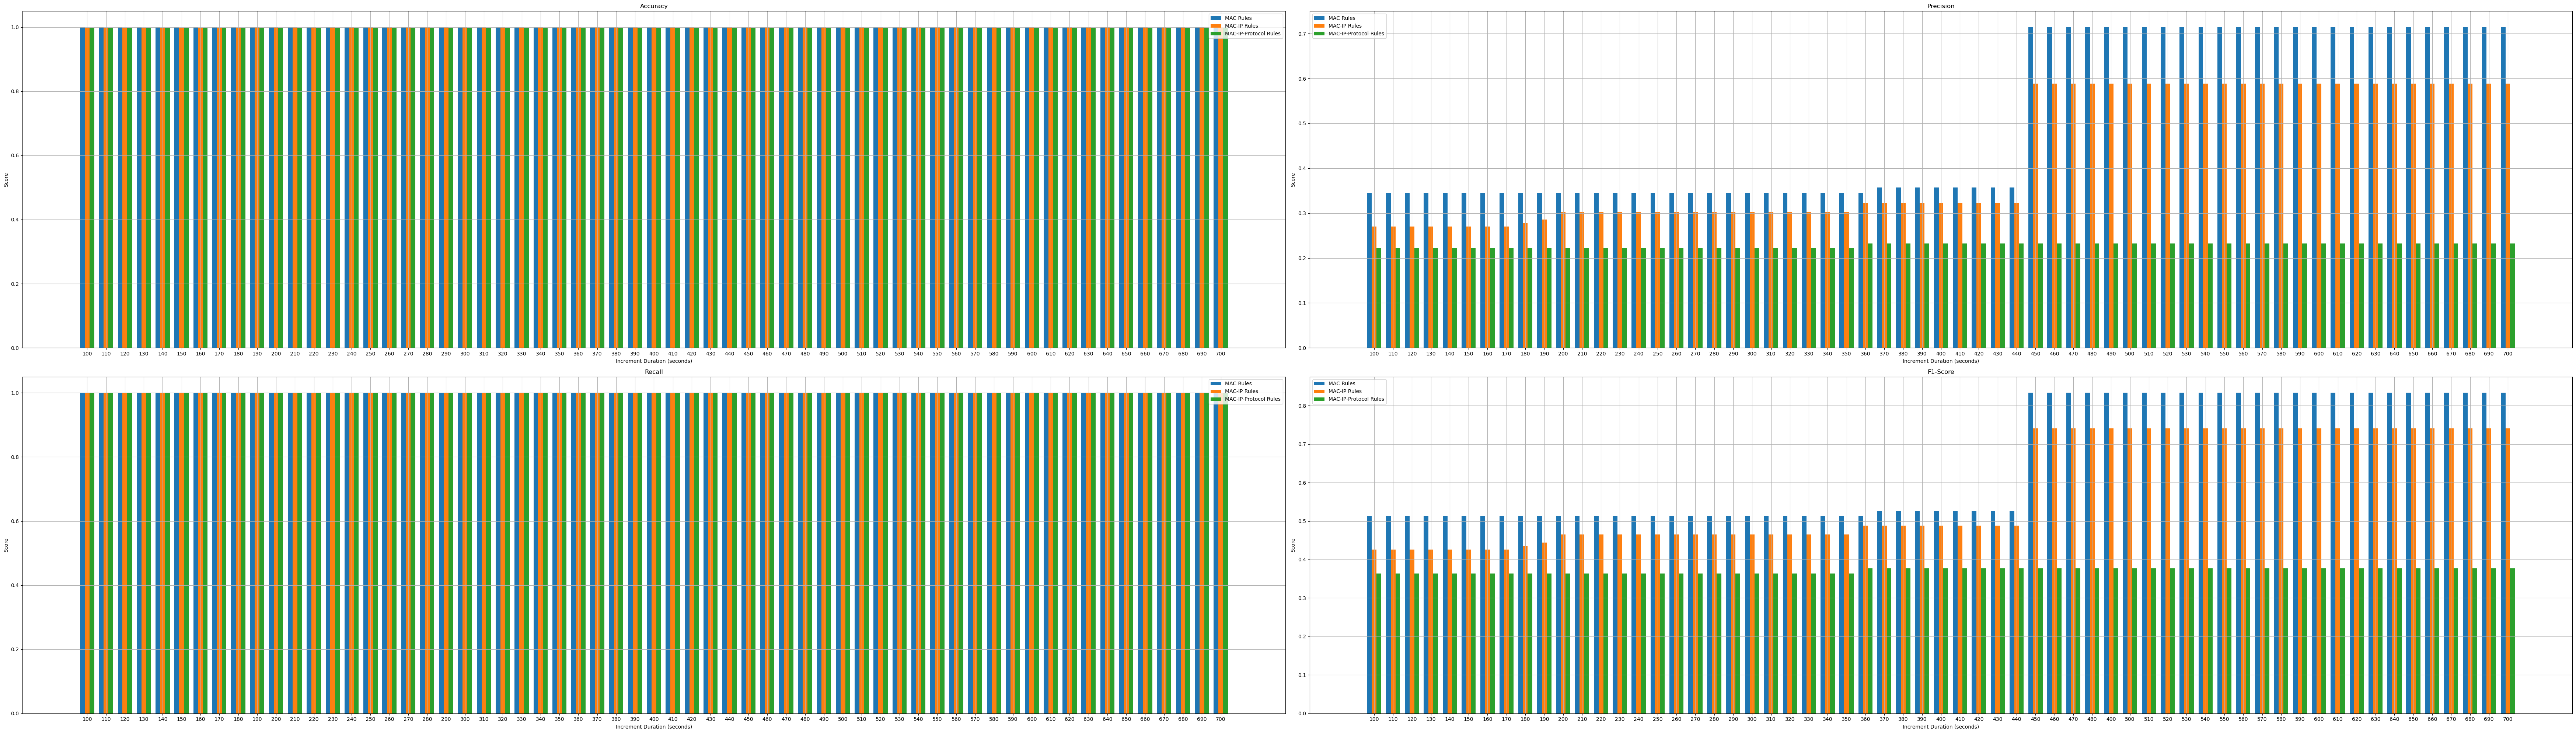

In [17]:

# Plots
fig, axs = plt.subplots(2, 2, figsize=(70, 20))

x = np.arange(len(increment_durations))
width = 0.25

# Accuracy
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 0].bar(x + i * width, all_accuracies[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 0].set_xticks(x + width)
axs[0, 0].set_xticklabels(range(100, 701, 10))
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Precision
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 1].bar(x + i * width, all_precisions[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 1].set_xticks(x + width)
axs[0, 1].set_xticklabels(range(100, 701, 10))
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Recall
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 0].bar(x + i * width, all_recalls[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 0].set_xticks(x + width)
axs[1, 0].set_xticklabels(range(100, 701, 10))
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plotting F1-Score
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 1].bar(x + i * width, all_f1s[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 1].set_xticks(x + width)
axs[1, 1].set_xticklabels(range(100, 701, 10))
axs[1, 1].set_title('F1-Score')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set_xlabel('Increment Duration (seconds)')
    ax.set_ylabel('Score')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Random 600 seonds

In [25]:
random_start = random.uniform(start_time, end_time - 600)
random_end = random_start + 600


increment_durations = list(range(int(random_start), int(random_end), 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

for end in increment_durations:
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, end - 10, end)
    
    # Merge the base rules
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((end - int(random_start), metrics))

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    print(f"Duration: {duration} seconds")
    print(f"MAC Rules - Accuracy: {mac_metrics[4]:.4f}, Precision: {mac_metrics[5]:.4f}, Recall: {mac_metrics[6]:.4f}, F1-Score: {mac_metrics[7]:.4f}")
    print(f"MAC-IP Rules - Accuracy: {mac_ip_metrics[4]:.4f}, Precision: {mac_ip_metrics[5]:.4f}, Recall: {mac_ip_metrics[6]:.4f}, F1-Score: {mac_ip_metrics[7]:.4f}")
    print(f"MAC-IP-Protocol Rules - Accuracy: {mac_ip_proto_metrics[4]:.4f}, Precision: {mac_ip_proto_metrics[5]:.4f}, Recall: {mac_ip_proto_metrics[6]:.4f}, F1-Score: {mac_ip_proto_metrics[7]:.4f}")
    print()

all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for duration, metrics in results:
    mac_metrics = metrics['mac']
    mac_ip_metrics = metrics['mac_ip']
    mac_ip_proto_metrics = metrics['mac_ip_proto']

    accuracy = [mac_metrics[4], mac_ip_metrics[4], mac_ip_proto_metrics[4]]
    precision = [mac_metrics[5], mac_ip_metrics[5], mac_ip_proto_metrics[5]]
    recall = [mac_metrics[6], mac_ip_metrics[6], mac_ip_proto_metrics[6]]
    f1 = [mac_metrics[7], mac_ip_metrics[7], mac_ip_proto_metrics[7]]

    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

# Transpose metrics 
all_accuracies = np.array(all_accuracies).T
all_precisions = np.array(all_precisions).T
all_recalls = np.array(all_recalls).T
all_f1s = np.array(all_f1s).T


Duration: 0 seconds
MAC Rules - Accuracy: 0.9996, Precision: 0.7143, Recall: 1.0000, F1-Score: 0.8333
MAC-IP Rules - Accuracy: 0.9994, Precision: 0.5882, Recall: 1.0000, F1-Score: 0.7407
MAC-IP-Protocol Rules - Accuracy: 0.9970, Precision: 0.2326, Recall: 1.0000, F1-Score: 0.3774

Duration: 10 seconds
MAC Rules - Accuracy: 0.9996, Precision: 0.7143, Recall: 1.0000, F1-Score: 0.8333
MAC-IP Rules - Accuracy: 0.9994, Precision: 0.5882, Recall: 1.0000, F1-Score: 0.7407
MAC-IP-Protocol Rules - Accuracy: 0.9970, Precision: 0.2326, Recall: 1.0000, F1-Score: 0.3774

Duration: 20 seconds
MAC Rules - Accuracy: 0.9996, Precision: 0.7143, Recall: 1.0000, F1-Score: 0.8333
MAC-IP Rules - Accuracy: 0.9994, Precision: 0.5882, Recall: 1.0000, F1-Score: 0.7407
MAC-IP-Protocol Rules - Accuracy: 0.9970, Precision: 0.2326, Recall: 1.0000, F1-Score: 0.3774

Duration: 30 seconds
MAC Rules - Accuracy: 0.9996, Precision: 0.7143, Recall: 1.0000, F1-Score: 0.8333
MAC-IP Rules - Accuracy: 0.9994, Precision: 0.588

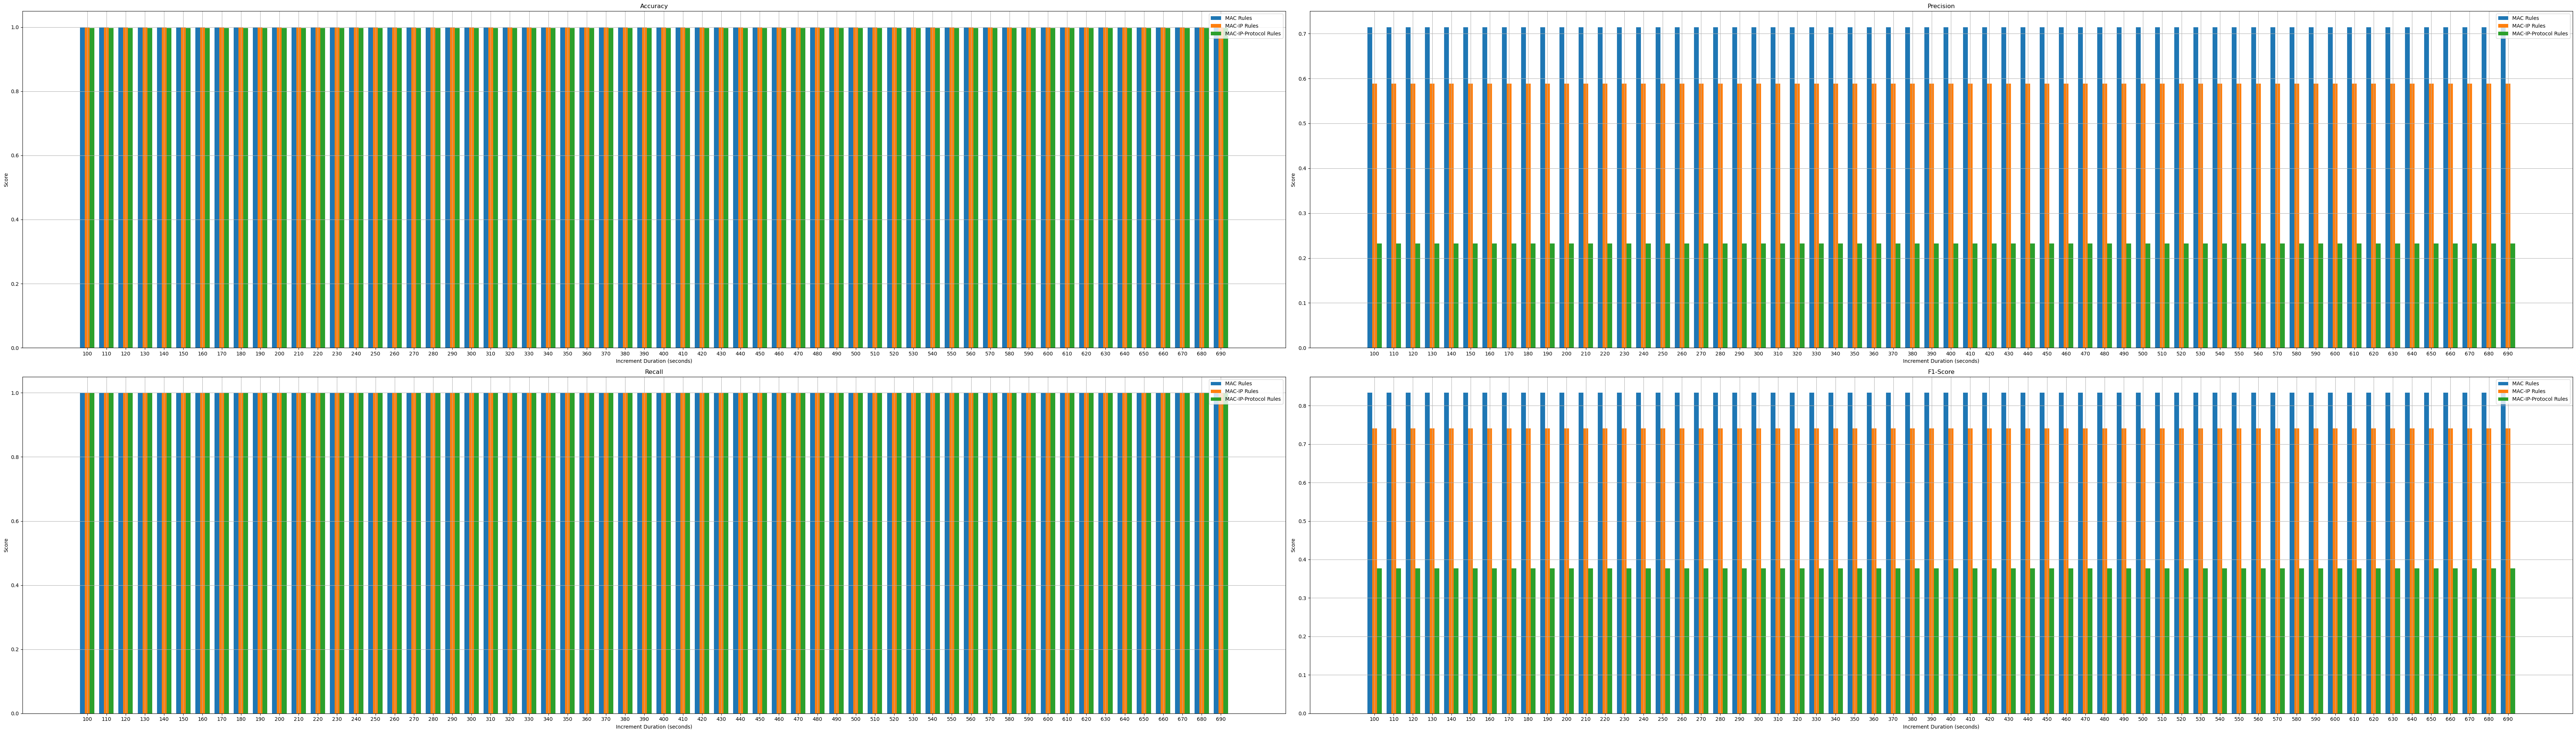

In [29]:
# Plots
fig, axs = plt.subplots(2, 2, figsize=(70, 20))

x = np.arange(len(increment_durations))
width = 0.25

# Accuracy
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 0].bar(x + i * width, all_accuracies[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 0].set_xticks(x + width)
axs[0, 0].set_xticklabels(range(100, 700, 10))  
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Precision
for i, rule_type in enumerate(rule_types):
    bars = axs[0, 1].bar(x + i * width, all_precisions[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[0, 1].set_xticks(x + width)
axs[0, 1].set_xticklabels(range(100, 700, 10))  
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Recall
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 0].bar(x + i * width, all_recalls[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 0].set_xticks(x + width)
axs[1, 0].set_xticklabels(range(100, 700, 10))  
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plotting F1-Score
for i, rule_type in enumerate(rule_types):
    bars = axs[1, 1].bar(x + i * width, all_f1s[i], width, label=rule_type)
    mplcursors.cursor(bars, hover=True)
axs[1, 1].set_xticks(x + width)
axs[1, 1].set_xticklabels(range(100, 700, 10))  
axs[1, 1].set_title('F1-Score')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set_xlabel('Increment Duration (seconds)')
    ax.set_ylabel('Score')
    ax.grid(True)

plt.tight_layout()
plt.show()


C:\Users\IRFAN\AppData\Local\Temp\ipykernel_1472\2708632665.py:184: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(increment_durations, mean_f1s, yerr=std_f1s, fmt='o', ecolor='blue', capsize=5, capthick=2, linestyle='-', color='blue', marker='o', markersize=5)


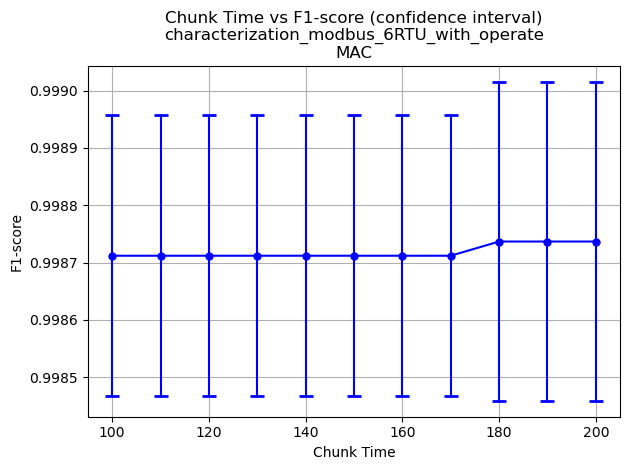

In [2]:
import subprocess
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

# Function to get the start and end time of a PCAP file
def get_pcap_duration(pcap_file):
    tshark_cmd = ["tshark", "-r", pcap_file, "-T", "fields", "-e", "frame.time_epoch"]
    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    times = [float(line) for line in output.strip().split("\n")]
    start_time = min(times)
    end_time = max(times)
    return start_time, end_time

# Function to extract rules from PCAP file
def extract_rules_tshark(pcap_file, start, end):
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        '-E', 'occurrence=f',
        '-E', 'quote=d',
        '-e', 'ip.src',
        '-e', 'ip.dst',
        '-e', 'tcp.srcport',
        '-e', 'tcp.dstport',
        '-e', 'frame.time_epoch',
        '-e', 'frame.len',
        '-e', 'ip.proto',
        '-e', '_ws.col.Protocol',
        '-e', 'eth.src',
        '-e', 'eth.dst',
        '-e', 'udp.srcport',
        '-e', 'udp.dstport'
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    df = df[(df['frame.time_epoch'] >= start) & (df['frame.time_epoch'] <= end)]

    mac_rules = set(zip(df['eth.src'], df['eth.dst']))
    mac_ip_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst']))
    mac_ip_proto_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst'], df['ip.proto']))

    return mac_rules, mac_ip_rules, mac_ip_proto_rules

# Function to check anomalies in a PCAP file
def check_anomalies_tshark(pcap_file, normal_rules):
    mac_rules, mac_ip_rules, mac_ip_proto_rules = normal_rules
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        "-e", "frame.time_epoch",
        "-e", "eth.src",
        "-e", "eth.dst",
        "-e", "ip.src",
        "-e", "ip.dst",
        "-e", "ip.proto"
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    anomalies = []

    for _, row in df.iterrows():
        eth_src = row['eth.src']
        eth_dst = row['eth.dst']
        ip_src = row['ip.src']
        ip_dst = row['ip.dst']
        proto = row['ip.proto']

        mac_anomaly = 1 if (eth_src, eth_dst) not in mac_rules else 0
        mac_ip_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst) not in mac_ip_rules else 0
        mac_ip_proto_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst, proto) not in mac_ip_proto_rules else 0

        anomalies.append({
            'eth_src': eth_src,
            'eth_dst': eth_dst,
            'ip_src': ip_src,
            'ip_dst': ip_dst,
            'proto': proto,
            'mac_anomaly': mac_anomaly,
            'mac_ip_anomaly': mac_ip_anomaly,
            'mac_ip_proto_anomaly': mac_ip_proto_anomaly
        })

    return pd.DataFrame(anomalies)

# Function to evaluate anomalies against true labels
def evaluate_anomalies(anomalies_df, true_labels_df):
    min_length = min(len(anomalies_df), len(true_labels_df))
    anomalies_df = anomalies_df.iloc[:min_length]
    true_labels_df = true_labels_df.iloc[:min_length]

    anomalies_df.index = true_labels_df.index

    metrics = {}

    def compute_metrics(y_true, y_pred):
        from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return tn, fp, fn, tp, accuracy, precision, recall, f1

    metrics['mac'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_anomaly'])
    metrics['mac_ip'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_anomaly'])
    metrics['mac_ip_proto'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_proto_anomaly'])

    return metrics

# Function to process PCAP file and evaluate
def process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules):
    anomalies_df = check_anomalies_tshark(pcap_attack, normal_rules)
    true_labels_df = pd.read_csv(true_labels_csv, sep=';', header=None)
    true_labels_df.columns = ['index', 'label']
    true_labels_df.set_index('index', inplace=True)
    return evaluate_anomalies(anomalies_df, true_labels_df)

# Main pipeline
pcap_normal = 'normal.pcap'
pcap_attack = 'characterization_modbus_6RTU_with_operate.pcap'
true_labels_csv = 'characterization_modbus_6RTU_with_operate_labeled.csv'

# Get the start and end times of the normal pcap
start_time, end_time = get_pcap_duration(pcap_normal)

# Base duration for the first 100 seconds
base_duration = 100
base_start = start_time
base_end = start_time + base_duration

# Durations for incremental segments
increment_durations = list(range(100, 201, 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

# Extract rules for the base 100 seconds
combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, base_start, base_end)

for increment in increment_durations:
    end = start_time + increment
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, start_time, end)
    
    # Merge the base rules with the new increment rules
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((increment, metrics))

# Aggregating the F1-scores
all_f1s = []

for _, metrics in results:
    f1 = [
        metrics['mac'][7],
        metrics['mac_ip'][7],
        metrics['mac_ip_proto'][7]
    ]
    all_f1s.append(f1)

all_f1s = np.array(all_f1s)

# Calculating mean and standard deviation
mean_f1s = np.mean(all_f1s, axis=1)
std_f1s = np.std(all_f1s, axis=1)

# Plotting the results
plt.errorbar(increment_durations, mean_f1s, yerr=std_f1s, fmt='o', ecolor='blue', capsize=5, capthick=2, linestyle='-', color='blue', marker='o', markersize=5)

# Labeling the plot
plt.title('Chunk Time vs F1-score (confidence interval)\ncharacterization_modbus_6RTU_with_operate\nMAC')
plt.xlabel('Chunk Time')
plt.ylabel('F1-score')

# Adding grid and tight layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\IRFAN\AppData\Local\Temp\ipykernel_1472\1888804210.py:184: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(increment_durations, mean_f1s, yerr=std_f1s, fmt='o', ecolor='blue', capsize=5, capthick=2, linestyle='-', color='blue', marker='o', markersize=5)


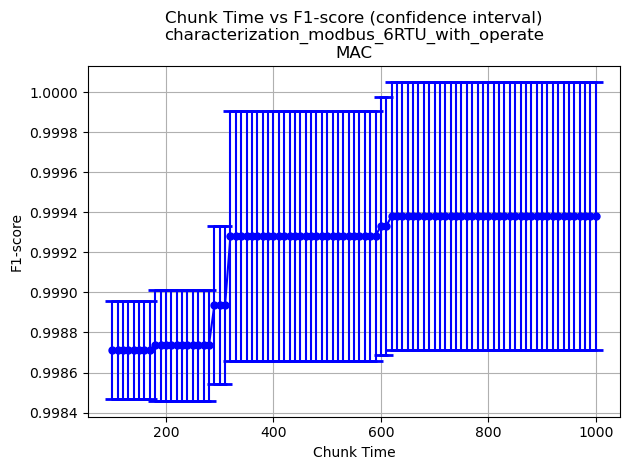

In [4]:
import subprocess
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

# Function to get the start and end time of a PCAP file
def get_pcap_duration(pcap_file):
    tshark_cmd = ["tshark", "-r", pcap_file, "-T", "fields", "-e", "frame.time_epoch"]
    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    times = [float(line) for line in output.strip().split("\n")]
    start_time = min(times)
    end_time = max(times)
    return start_time, end_time

# Function to extract rules from PCAP file
def extract_rules_tshark(pcap_file, start, end):
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        '-E', 'occurrence=f',
        '-E', 'quote=d',
        '-e', 'ip.src',
        '-e', 'ip.dst',
        '-e', 'tcp.srcport',
        '-e', 'tcp.dstport',
        '-e', 'frame.time_epoch',
        '-e', 'frame.len',
        '-e', 'ip.proto',
        '-e', '_ws.col.Protocol',
        '-e', 'eth.src',
        '-e', 'eth.dst',
        '-e', 'udp.srcport',
        '-e', 'udp.dstport'
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    df = df[(df['frame.time_epoch'] >= start) & (df['frame.time_epoch'] <= end)]

    mac_rules = set(zip(df['eth.src'], df['eth.dst']))
    mac_ip_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst']))
    mac_ip_proto_rules = set(zip(df['eth.src'], df['ip.src'], df['eth.dst'], df['ip.dst'], df['ip.proto']))

    return mac_rules, mac_ip_rules, mac_ip_proto_rules

# Function to check anomalies in a PCAP file
def check_anomalies_tshark(pcap_file, normal_rules):
    mac_rules, mac_ip_rules, mac_ip_proto_rules = normal_rules
    tshark_cmd = [
        "tshark",
        "-r", pcap_file,
        "-T", "fields",
        "-E", "separator=,",
        "-E", "header=y",
        "-e", "frame.time_epoch",
        "-e", "eth.src",
        "-e", "eth.dst",
        "-e", "ip.src",
        "-e", "ip.dst",
        "-e", "ip.proto"
    ]

    result = subprocess.run(tshark_cmd, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    df = pd.read_csv(StringIO(output))
    anomalies = []

    for _, row in df.iterrows():
        eth_src = row['eth.src']
        eth_dst = row['eth.dst']
        ip_src = row['ip.src']
        ip_dst = row['ip.dst']
        proto = row['ip.proto']

        mac_anomaly = 1 if (eth_src, eth_dst) not in mac_rules else 0
        mac_ip_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst) not in mac_ip_rules else 0
        mac_ip_proto_anomaly = 1 if (eth_src, ip_src, eth_dst, ip_dst, proto) not in mac_ip_proto_rules else 0

        anomalies.append({
            'eth_src': eth_src,
            'eth_dst': eth_dst,
            'ip_src': ip_src,
            'ip_dst': ip_dst,
            'proto': proto,
            'mac_anomaly': mac_anomaly,
            'mac_ip_anomaly': mac_ip_anomaly,
            'mac_ip_proto_anomaly': mac_ip_proto_anomaly
        })

    return pd.DataFrame(anomalies)

# Function to evaluate anomalies against true labels
def evaluate_anomalies(anomalies_df, true_labels_df):
    min_length = min(len(anomalies_df), len(true_labels_df))
    anomalies_df = anomalies_df.iloc[:min_length]
    true_labels_df = true_labels_df.iloc[:min_length]

    anomalies_df.index = true_labels_df.index

    metrics = {}

    def compute_metrics(y_true, y_pred):
        from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return tn, fp, fn, tp, accuracy, precision, recall, f1

    metrics['mac'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_anomaly'])
    metrics['mac_ip'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_anomaly'])
    metrics['mac_ip_proto'] = compute_metrics(true_labels_df['label'], anomalies_df['mac_ip_proto_anomaly'])

    return metrics

# Function to process PCAP file and evaluate
def process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules):
    anomalies_df = check_anomalies_tshark(pcap_attack, normal_rules)
    true_labels_df = pd.read_csv(true_labels_csv, sep=';', header=None)
    true_labels_df.columns = ['index', 'label']
    true_labels_df.set_index('index', inplace=True)
    return evaluate_anomalies(anomalies_df, true_labels_df)

# Main pipeline
pcap_normal = 'normal.pcap'
pcap_attack = 'characterization_modbus_6RTU_with_operate.pcap'
true_labels_csv = 'characterization_modbus_6RTU_with_operate_labeled.csv'

# Get the start and end times of the normal pcap
start_time, end_time = get_pcap_duration(pcap_normal)

# Base duration for the first 100 seconds
base_duration = 100
base_start = start_time
base_end = start_time + base_duration

# Durations for incremental segments
increment_durations = list(range(100, 1001, 10))
results = []

rule_types = ['MAC Rules', 'MAC-IP Rules', 'MAC-IP-Protocol Rules']

# Extract rules for the base 100 seconds
combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, base_start, base_end)

for increment in increment_durations:
    end = start_time + increment
    normal_mac_rules, normal_mac_ip_rules, normal_mac_ip_proto_rules = extract_rules_tshark(pcap_normal, start_time, end)
    
    # Merge the base rules with the new increment rules
    combined_mac_rules = combined_mac_rules.union(normal_mac_rules)
    combined_mac_ip_rules = combined_mac_ip_rules.union(normal_mac_ip_rules)
    combined_mac_ip_proto_rules = combined_mac_ip_proto_rules.union(normal_mac_ip_proto_rules)
    normal_rules = (combined_mac_rules, combined_mac_ip_rules, combined_mac_ip_proto_rules)
    
    metrics = process_pcap_and_evaluate(pcap_attack, true_labels_csv, normal_rules)
    results.append((increment, metrics))

# Aggregating the F1-scores
all_f1s = []

for _, metrics in results:
    f1 = [
        metrics['mac'][7],
        metrics['mac_ip'][7],
        metrics['mac_ip_proto'][7]
    ]
    all_f1s.append(f1)

all_f1s = np.array(all_f1s)

# Calculating mean and standard deviation
mean_f1s = np.mean(all_f1s, axis=1)
std_f1s = np.std(all_f1s, axis=1)

# Plotting the results
plt.errorbar(increment_durations, mean_f1s, yerr=std_f1s, fmt='o', ecolor='blue', capsize=5, capthick=2, linestyle='-', color='blue', marker='o', markersize=5)

# Labeling the plot
plt.title('Chunk Time vs F1-score (confidence interval)\ncharacterization_modbus_6RTU_with_operate\nMAC')
plt.xlabel('Chunk Time')
plt.ylabel('F1-score')

# Adding grid and tight layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
